In [43]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as d
import matplotlib.pyplot as plt
import json
import sklearn

In [44]:
#Parameters
time_length = 60; #seconds
sampletot = 20000
samplenum = 15000
testsize = 1-samplenum/sampletot
epochs = 250
minibatch_size= 50
hiddenlayers = [100]
input_size = 3
output_size = 3*time_length
learning_rate = 0.01
LRdecay = 0.7

In [45]:
#Load Samples

with open('Data/Samples/data_20k.json') as json_file:
    data = json.load(json_file)
    p = np.zeros((3*time_length, data['Description'][0]['samplenum']))
    y_target = np.zeros((data['Description'][0]['samplenum'], 3))
    for i, p_i in enumerate(data['parameter']):
        p[:, i] = np.array(p_i)
    for s, y_s in enumerate(data['y_target']):
        y_target[s, :] = np.array(y_s)
        #y_target[s, 1] = y_target[s, 1]-1 #min-max scaling 
p = p.transpose()

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
y_train, y_test, p_train, p_test = train_test_split(y_target, p, test_size = testsize)

y_target = torch.tensor(y_train).float()
p = torch.tensor(p_train).float()
y_test = torch.tensor(y_test).float()
p_test = torch.tensor(p_test).float()

## Building the custon Simulation activation function and model

In [46]:
class ActiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(ActiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, hiddenlayers[0])
        #self.H1 = nn.Linear(hiddenlayers[0], 3*time_length)
        self.H1 = nn.Linear(hiddenlayers[0], 3*time_length)
        #self.H2 = nn.Linear(hiddenlayers[1], hiddenlayers[2])
        #self.H2 = nn.Linear(hiddenlayers[1], 3*time_length)
        #self.H3 = nn.Linear(hiddenlayers[2], 3*time_length)
        #self.H3 = nn.Linear(hiddenlayers[2], hiddenlayers[3])
        #self.H4 = nn.Linear(hiddenlayers[3], 3*time_length)
        self.L_out = nn.Linear(3*time_length, 3*time_length)
        self.Relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=0.5)
    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        #x = self.drop(x)
        x = self.H1(x)
        x = self.Relu(x)
        #x = self.H2(x)
        #x = self.Relu(x)
        #x = self.H3(x)
        #x = self.Relu(x)
        #x = self.H4(x)
        x = self.L_out(x)
        return x


model = ActiveLearn(input_size, output_size)

criterion = nn.SmoothL1Loss()  # RMSE = np.sqrt(MSE)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=LRdecay, last_epoch=-1)
#scheduler= torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr = 0.000001, max_lr = 0.01, mode = "exp_range")

## Train the model

epoch:   0/250    LR:   0.010000  loss: 0.00001996
epoch:  50/250    LR:   0.003430  loss: 0.00000100
epoch: 100/250    LR:   0.001176  loss: 0.00000016
epoch: 150/250    LR:   0.000282  loss: 0.00000003
epoch: 200/250    LR:   0.000097  loss: 0.00000003
epoch: 249 final loss: 0.00000002

Duration: 25.520 min


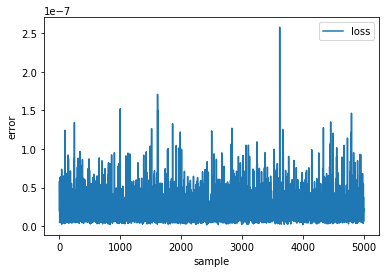

0.00011087375897611551


In [47]:
torch.autograd.set_detect_anomaly(True)

start_time = time.time()
weight_c1 = 1 # p error condition
batch = np.floor(samplenum/minibatch_size).astype(int)
losses= []
p_smoothness_errors = []
basic_errors = [] #y_end_ and p_start error
for e in range(epochs):
    for b in range(batch):
        loss_batch = 0
        smoothness_error_batch = 0
        y_i = y_target[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_i = p[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_pred = model(y_i)

        #error claculation
        p_error = weight_c1* criterion(p_pred, p_i)
        loss = p_error
        losses.append(loss)
        optimizer.zero_grad()
        #Back Prop
        loss.backward()
        optimizer.step()
    scheduler.step()
    LR= scheduler.get_lr()
    if e%50 == 0:
        print(f'epoch: {e:3}/{epochs}    LR: {LR[0]:10.6f}  loss: {loss.item():10.8f}')
    

print(f'epoch: {e:3} final loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed


#Test the data
losses_test= []
with torch.no_grad():
    for i in range(sampletot-samplenum):
        p_val = model(y_test[i, :])
        loss2 = criterion(p_val,p_test[i,:])
        losses_test.append(loss2.clone().numpy())
#plot test errors
loss2 = plt.plot(losses_test, label = 'loss')
plt.legend()
plt.ylabel('error')
plt.xlabel('sample')
plt.show()
tot_error = sum(losses_test)
print(tot_error)

## PLOTS

In [ ]:
#Load model
#model = torch.load('Trained_Models/Model_290620_15000s_200e_60t.pt')

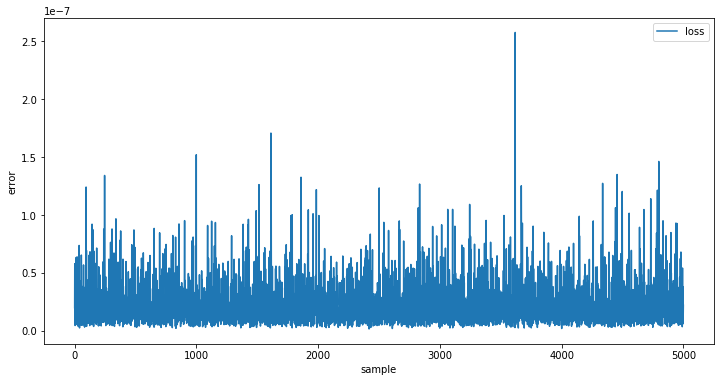

0.00011087375897611551


In [52]:
#plot test errors
plt.figure(figsize = [12,6])
loss2 = plt.plot(losses_test, label = 'loss')
plt.legend()
plt.ylabel('error')
plt.xlabel('sample')
plt.show()
tot_error = sum(losses_test)
print(tot_error)

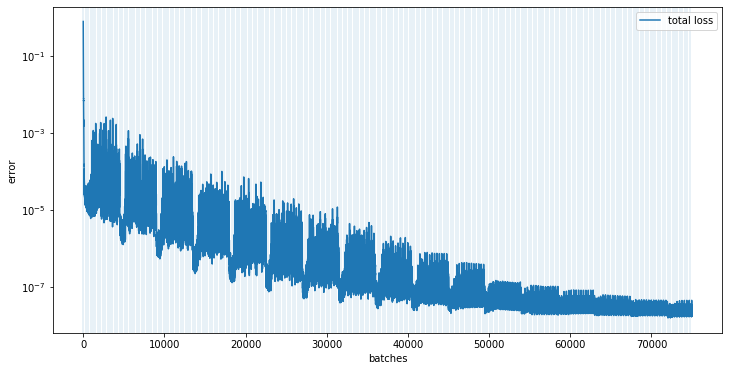

In [53]:
#plot errors for each batch after each epoch
epoch_lines = np.arange(0, epochs*batch, batch)
plt.figure(figsize = [12,6])
loss = plt.plot(losses, label = 'total loss')
plt.legend()
plt.yscale('log')
plt.ylabel('error')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.show()

In [102]:
#relative error
rel_errors_norm = []
with torch.no_grad():
    for i in range(sampletot-samplenum):
            p_val = model(y_test[i, :])
            p_truth = p_test[i,:]
            rel_error = np.linalg.norm((p_val - p_truth)/p_truth)
            rel_errors_norm.append(rel_error)
#plt.plot(rel_errors_norm)
#plt.show
#relative error vs. time
rel_errors_sum = torch.zeros(180)
abs_errors_sum = torch.zeros(180)
with torch.no_grad():
    for i in range(sampletot-samplenum):
            p_val = model(y_test[i, :])
            p_truth = p_test[i,:]
            rel_error = (p_val - p_truth)/p_truth
            abs_error = (np.abs(p_val - p_truth))/5000
            rel_errors_sum = rel_errors_sum + rel_error
            abs_errors_sum = abs_errors_sum + abs_error
x_err_rel = rel_errors_sum[0::3]
y_err_rel = rel_errors_sum[1::3]
z_err_rel = rel_errors_sum[2::3]

x_err = abs_errors_sum[0::3]
y_err = abs_errors_sum[1::3]
z_err = abs_errors_sum[2::3]

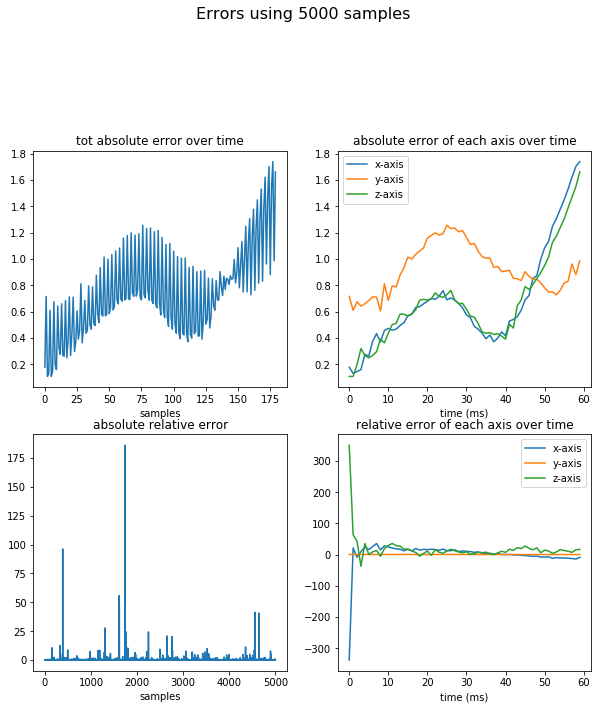

In [101]:
plt.figure(figsize = [10,20])
plt.suptitle('Errors using 5000 samples', fontsize=16)

plt.subplot(4, 2, 1)
plt.plot(abs_errors_sum)
plt.xlabel('samples')
plt.title('tot absolute error over time')

plt.subplot(4, 2, 4)
plt.plot(x_err_rel, label = 'x-axis')
plt.plot(y_err_rel, label = 'y-axis')
plt.plot(z_err_rel, label = 'z-axis')
plt.xlabel('time (ms)')
plt.title('relative error of each axis over time')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(x_err, label = 'x-axis')
plt.plot(y_err, label = 'y-axis')
plt.plot(z_err, label = 'z-axis')
plt.xlabel('time (ms)')
plt.title('absolute error of each axis over time')
plt.legend()


plt.subplot(4, 2, 3)
plt.plot(rel_errors_norm)
plt.xlabel('samples')
plt.title('absolute relative error')

plt.show()

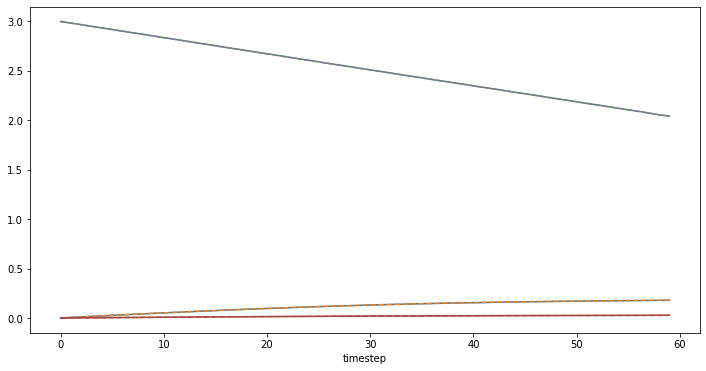

In [35]:
#x, y and z plot
randomsample = 9
with torch.no_grad():
        p_val = model(y_test[randomsample, :])
        p_truth = p_test[randomsample,:]
        x_val = p_val[0::3]
        y_val = p_val[1::3]
        z_val = p_val[2::3]
        x_truth = p_truth[0::3]
        y_truth = p_truth[1::3]
        z_truth = p_truth[2::3]
            

plt.figure(figsize = [12,6])
plt.plot(x_val)
plt.plot(x_truth, '--')
plt.plot(y_val)
plt.plot(z_val)
plt.plot(y_truth, '--')
plt.plot(z_truth, '--')

plt.xlabel('timestep')
plt.show()

In [48]:
#Save parameters of Model
torch.save(model.state_dict(), 'Trained_Models/Trained_Model300620_15000s_250e_07lr.pt')

In [49]:
#Save entire Model
torch.save(model, 'Trained_Models/Model_300620_supervised_15k_samples.pt')

## Test forward propagation

In [99]:
# Generate simulation
dyn = d.PyDyn('Data/point-mass_pendulum.sim', time_length)
state_init = dyn.compute(dyn.p_init)
f = dyn.f(state_init, dyn.p_init)
df = dyn.df_dp(state_init, dyn.p_init)
dy = dyn.dy_dp(state_init, dyn.p_init)

y_target_test_= torch.tensor([0.5, 1.5, 0.5])
p_ = model(y_target_test_)
y_target_ = y_target_test_.detach().numpy()
p_ = p_.detach().numpy()
p_truth_ = dyn.get_p(y_target_, dyn.p_init)


yTraj_test_ = dyn.compute(p_)
yTraj_truth_ = dyn.compute(p_truth_)

print(f'evaluated y_end: {yTraj_test_.y[-3:]}')
print(f'simulated traj_opt y_end: {yTraj_truth_.y[-3:]}')
print(f'difference of y_end: {np.sum(yTraj_test_.y[-3:]-y_target_)}')
print(f'p predicted: {p_[-6:].transpose()}')
print(f'p simulated traj_opt: {p_truth_[-6:].transpose()}')

evaluated y_end: [0.492598   1.50978529 0.49229771]
simulated traj_opt y_end: [0.49261978 1.5094285  0.49261994]
difference of y_end: -0.005319002090217018
p predicted: [0.35870972 2.5016336  0.35973907 0.35993925 2.4927075  0.3610821 ]
p simulated traj_opt: [0.35960398 2.50145068 0.35959234 0.36085268 2.49238083 0.36084115]


## Torch Script Conversion and Saving

In [50]:
input_example = torch.tensor([0, 2, 0.5])
traced_script_module = torch.jit.trace(model, input_example)

# Test the torch script
test_input = torch.tensor([0, 2, 0.5])
original = model(test_input)
output_example = traced_script_module(test_input)

tensor([-1.0927e-03,  2.9921e+00,  3.4112e-01, -1.1927e-03,  2.9914e+00,
         3.4142e-01, -1.2227e-03,  2.9901e+00,  3.4185e-01, -1.3486e-03,
         2.9892e+00,  3.4216e-01], grad_fn=<SliceBackward>)
tensor([-7.4441e-05,  3.0002e+00,  1.1921e-03,  8.3286e-05,  2.9995e+00,
         1.2774e-02,  9.9869e-05,  2.9989e+00,  2.4411e-02,  3.6005e-05,
         2.9980e+00,  3.5757e-02,  1.7736e-04,  2.9972e+00,  4.7197e-02,
         2.2172e-04,  2.9963e+00,  5.8519e-02,  3.1957e-04,  2.9953e+00,
         6.9660e-02,  2.5173e-04,  2.9942e+00,  8.0664e-02,  3.3909e-04,
         2.9930e+00,  9.1439e-02,  3.4545e-04,  2.9920e+00,  1.0213e-01,
         3.7261e-04,  2.9907e+00,  1.1263e-01,  3.1963e-04,  2.9897e+00,
         1.2305e-01,  3.2508e-04,  2.9884e+00,  1.3319e-01,  3.8802e-04,
         2.9873e+00,  1.4308e-01,  3.4975e-04,  2.9862e+00,  1.5284e-01,
         2.8430e-04,  2.9851e+00,  1.6231e-01,  4.2441e-04,  2.9840e+00,
         1.7162e-01,  3.7283e-04,  2.9832e+00,  1.8074e-01,  4.1

In [54]:
# Save serialized model
traced_script_module.save("Serialized_Models/CPP_example_model_omni_latest.pt")